# Batch Project for Data Engineering Pipeline Using AWS

This is a project done by Albert Lok to practice creating a data pipeline.
 Credit to @josephmachado for the project design and code.

The project covers these topics:

1. Set up Apache Airflow, AWS EMR, AWS Redshift, AWS Spectrum, and AWS S3.

2. Learn data pipeline best practices.

3. Learn how to spot failure points in data pipelines and build systems resistant to failures.

4. Learn how to design and build a data pipeline from business requirements.

## OBJECTIVE

The scenario is a user behavior analytics company that collects user data and creates a user profile. We are tasked with building a data pipeline to populate the `user_behavior_metric` table. The `user_behavior_metric` table is an OLAP table, meant to be used by analysts, dashboard software, etc. It is built from

1. `user_purchase`: OLTP table with user purchase information.
2. `movie_review.csv`: Data sent every day by an external data vendor.

![Entity Relationship Diagram](https://www.startdataengineering.com/images/de_project_for_beginners/de_proj_obj.png)

## DESIGN

We used Airflow to orchestrate the following tasks:

1. Classifying movie reviews with Apache Spark.
2. Loading the classified movie reviews into the data warehouse.
3. Extracting user purchase data from an OLTP database and loading it into the data warehouse.
4. Joining the classified movie review data and user purchase data to get `user behavior metric` data.
5. Visualized the data using Metabase

![Design Diagram](https://www.startdataengineering.com/images/de_project_for_beginners/de_proj_design.png)

## SETUP

To set up the AWS infrastructure, we set up and configured AWS CLI.  We have a script called setup_infra.sh that contains all the commands to set up on AWS us-east-1.  The setup script was run line by line to:

* create an EC2 instance
* create an S3 bucket
* create an IAM role for EC2 and S3 access
* attach policies to the IAM role
* create an ssh key to connect to the EC2 instance
* create an EC2 security group and modify inbound and outbound rules
* copy code from local to EC2 server
* create an EMR cluster
* create a Redshift cluster
* create tables on Redshift
* spin up an Airflow Docker container
* connect Redshift, postgres, S3, and EMR to Airflow
* create log files
* set up connections to Airflow UI and Metabase

AWS variables used were stored in infra_variables.txt.

Using AWS S3 as our data lake, data from external systems were stored here for further processing. AWS S3 was used as storage for use with AWS Redshift Spectrum.


In our project, we used one bucket with multiple folders:
* raw - to store raw data
* stage - to stage data for processing
* scripts - to store Spark script, for use by AWS EMR


The script created these tables in Redshift:
1. `retail.user_purchase` table, defined at `pgsetup/create_user_purchase.sql` in the repository. The data is mounted into the Postgres container’s file system. This data is loaded into the table using the COPY command.
2. `spectrum.user_purchase_staging` table, defined as having its data stored in the data lake’s stage location. Note that the table also has a partition defined on the insert_date.
3. `spectrum.classified_movie_review` table, defined as having its data stored in the data lake’s stage location.
4. `public.user_behavior_metric` table is the table that we want to load data into.

The script also created these Airflow connections and variables:
* redshift connection: To connect to the AWS Redshift cluster.
* postgres_default connection: To connect to the local Postgres database.
* BUCKET variable: To indicate the bucket to be used as the data lake for this pipeline.
* EMR_ID variable: To send commands to an AWS EMR cluster.

![Redshift Connections](https://www.startdataengineering.com/images/de_project_for_beginners/admin_conn.png)

## Code

The data for `user_behavior_metric` is generated from 2 main datasets.

### Loading user purchase data into the data warehouse
To load the user purchase data from Postgres into AWS Redshift we run the following tasks:

1. extract_user_purchase_data: Unloads data from Postgres to a local file system in the Postgres container. This filesystem is volume synced between our local Postgres and Airflow containers. This allows Airflow to access this data.
2. user_purchase_to_stage_data_lake: Moves the extracted data to data lake’s staging area at `stage/user_purchase/{{ ds }}/user_purchase.csv`, where ds will be replaced by the run date in `YYYY-MM-DD` format. This `ds` will serve as the `insert_date` partition, defined at table creation.
3. user_purchase_stage_data_lake_to_stage_tbl: Runs a Redshift query to make the `spectrum.user_purchase_staging` table aware of the new date partition.

```
extract_user_purchase_data = PostgresOperator(
    dag=dag,
    task_id="extract_user_purchase_data",
    sql="./scripts/sql/unload_user_purchase.sql",
    postgres_conn_id="postgres_default",
    params={"user_purchase": "/temp/user_purchase.csv"},
    depends_on_past=True,
    wait_for_downstream=True,
)

user_purchase_to_stage_data_lake = PythonOperator(
    dag=dag,
    task_id="user_purchase_to_stage_data_lake",
    python_callable=_local_to_s3,
    op_kwargs={
        "file_name": "/temp/user_purchase.csv",
        "key": "stage/user_purchase/{{ ds }}/user_purchase.csv",
        "bucket_name": BUCKET_NAME,
        "remove_local": "true",
    },
)

user_purchase_stage_data_lake_to_stage_tbl = PythonOperator(
    dag=dag,
    task_id="user_purchase_stage_data_lake_to_stage_tbl",
    python_callable=run_redshift_external_query,
    op_kwargs={
        "qry": "alter table spectrum.user_purchase_staging add if not exists partition(insert_date='{{ ds }}') \
            location 's3://"
        + BUCKET_NAME
        + "/stage/user_purchase/{{ ds }}'",
    },
)

extract_user_purchase_data >> user_purchase_to_stage_data_lake >> user_purchase_stage_data_lake_to_stage_tbl
```

SQL:
```
COPY (
       select invoice_number,
              stock_code,
              detail,
              quantity,
              invoice_date,
              unit_price,
              customer_id,
              country
       from retail.user_purchase -- we should have a date filter here to pull only required date's data
) TO '{{ params.user_purchase }}' WITH (FORMAT CSV, HEADER);
-- user_purchase will be replaced with /temp/user_purchase.csv from the params in extract_user_purchase_data task
```

### Loading classified movie review data into the data warehouse

To get the classified movie review data into AWS Redshift, we run the following tasks:

1. movie_review_to_raw_data_lake: Copies local file `data/movie_review.csv` to data lake’s raw area.
2. spark_script_to_s3: Copies our pyspark script to data lake’s script area. This allows AWS EMR to reference it.
3. start_emr_movie_classification_script: Adds the EMR steps defined at `dags/scripts/emr/clean_movie_review.json` to our EMR cluster. This task adds 3 EMR steps to the cluster, they do the following:
* Moves raw data from S3 to HDFS: Copies data from data lake’s raw area into EMR’s HDFS.
* Classifies movie reviews: Runs the review classification pyspark script.
* Moves classified data from HDFS to S3: Copies data from EMR’s HDFS to data lake’s staging area.
4. wait_for_movie_classification_transformation: This is a sensor task that waits for the final step (`Move classified data from HDFS to S3`) to finish.

```
movie_review_to_raw_data_lake = PythonOperator(
    dag=dag,
    task_id="movie_review_to_raw_data_lake",
    python_callable=_local_to_s3,
    op_kwargs={
        "file_name": "/data/movie_review.csv",
        "key": "raw/movie_review/{{ ds }}/movie.csv",
        "bucket_name": BUCKET_NAME,
    },
)

spark_script_to_s3 = PythonOperator(
    dag=dag,
    task_id="spark_script_to_s3",
    python_callable=_local_to_s3,
    op_kwargs={
        "file_name": "./dags/scripts/spark/random_text_classification.py",
        "key": "scripts/random_text_classification.py",
        "bucket_name": BUCKET_NAME,
    },
)

start_emr_movie_classification_script = EmrAddStepsOperator(
    dag=dag,
    task_id="start_emr_movie_classification_script",
    job_flow_id=EMR_ID,
    aws_conn_id="aws_default",
    steps=EMR_STEPS,
    params={
        "BUCKET_NAME": BUCKET_NAME,
        "raw_movie_review": "raw/movie_review",
        "text_classifier_script": "scripts/random_text_classifier.py",
        "stage_movie_review": "stage/movie_review",
    },
    depends_on_past=True,
)

last_step = len(EMR_STEPS) - 1

wait_for_movie_classification_transformation = EmrStepSensor(
    dag=dag,
    task_id="wait_for_movie_classification_transformation",
    job_flow_id=EMR_ID,
    step_id='{{ task_instance.xcom_pull("start_emr_movie_classification_script", key="return_value")['
    + str(last_step)
    + "] }}",
    depends_on_past=True,
)

[
    movie_review_to_raw_data_lake,
    spark_script_to_s3,
] >> start_emr_movie_classification_script >> wait_for_movie_classification_transformation
```

### Generating user behavior metric

With both the `user purchase` data and the `classified movie` data in the data warehouse, we can get the data for the `user_behavior_metric` table. This is done using the `generate_user_behavior_metric` task. This task runs a redshift SQL script to populate the `public.user_behavior_metric` table.

```
generate_user_behavior_metric = PostgresOperator(
    dag=dag,
    task_id="generate_user_behavior_metric",
    sql="scripts/sql/generate_user_behavior_metric.sql",
    postgres_conn_id="redshift",
)

end_of_data_pipeline = DummyOperator(task_id="end_of_data_pipeline", dag=dag) # dummy operator to indicate DAG complete

[
    user_purchase_stage_data_lake_to_stage_tbl,
    wait_for_movie_classification_transformation,
] >> generate_user_behavior_metric >> end_of_data_pipeline
```

The sql query generates customer level aggregate metrics, using `spectrum.user_purchase_staging` and `spectrum.classified_movie_review`:
```
-- scripts/sql/generate_user_behavior_metric.sql

DELETE FROM public.user_behavior_metric
WHERE insert_date = '{{ ds }}';
INSERT INTO public.user_behavior_metric (
        customerid,
        amount_spent,
        review_score,
        review_count,
        insert_date
    )
SELECT ups.customerid,
    CAST(
        SUM(ups.Quantity * ups.UnitPrice) AS DECIMAL(18, 5)
    ) AS amount_spent,
    SUM(mrcs.positive_review) AS review_score,
    count(mrcs.cid) AS review_count,
    '{{ ds }}'
FROM spectrum.user_purchase_staging ups
    JOIN (
        SELECT cid,
            CASE
                WHEN positive_review IS True THEN 1
                ELSE 0
            END AS positive_review
        FROM spectrum.classified_movie_review
        WHERE insert_date = '{{ ds }}'
    ) mrcs ON ups.customerid = mrcs.cid
WHERE ups.insert_date = '{{ ds }}'
GROUP BY ups.customerid;
```

## Airflow DAG

This is the DAG diagram from Airflow after everything had been loaded and was ready to run:
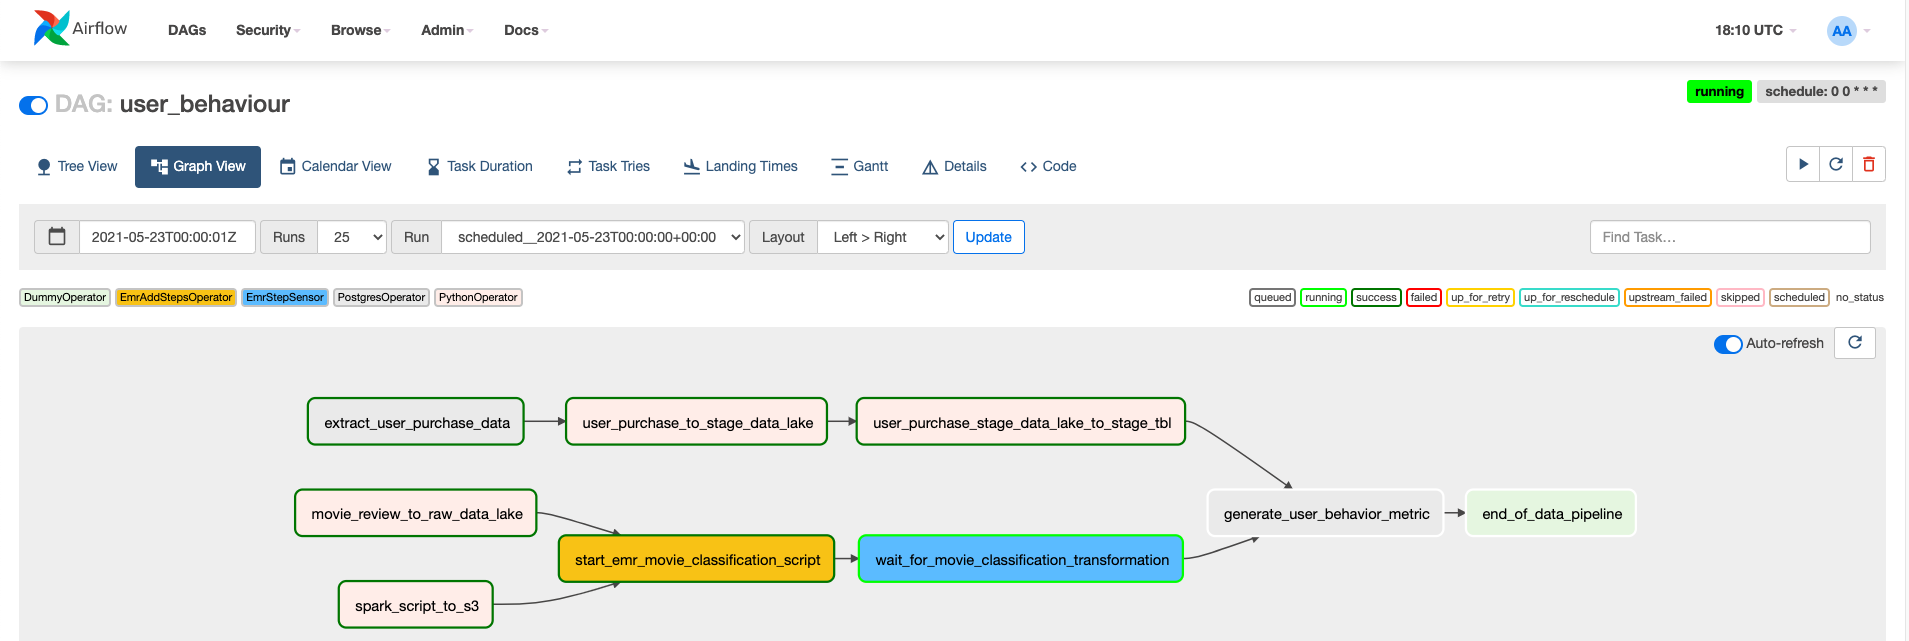

## Running the DAG and Verifying Activities

This is the DAG after some running:
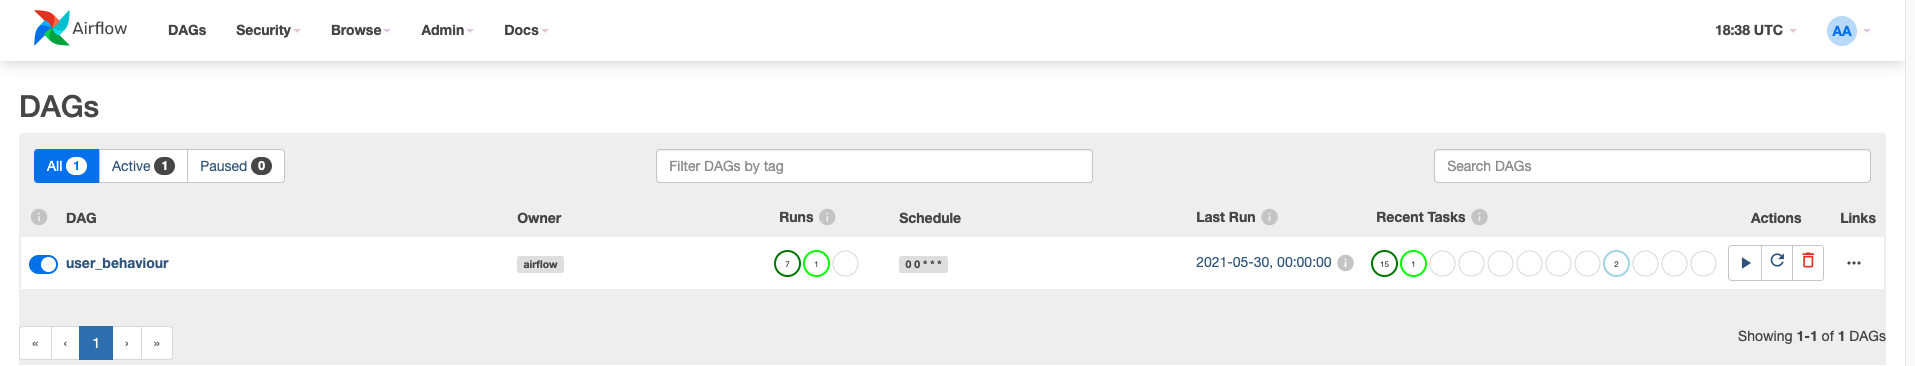

This is the EMR Cluster:
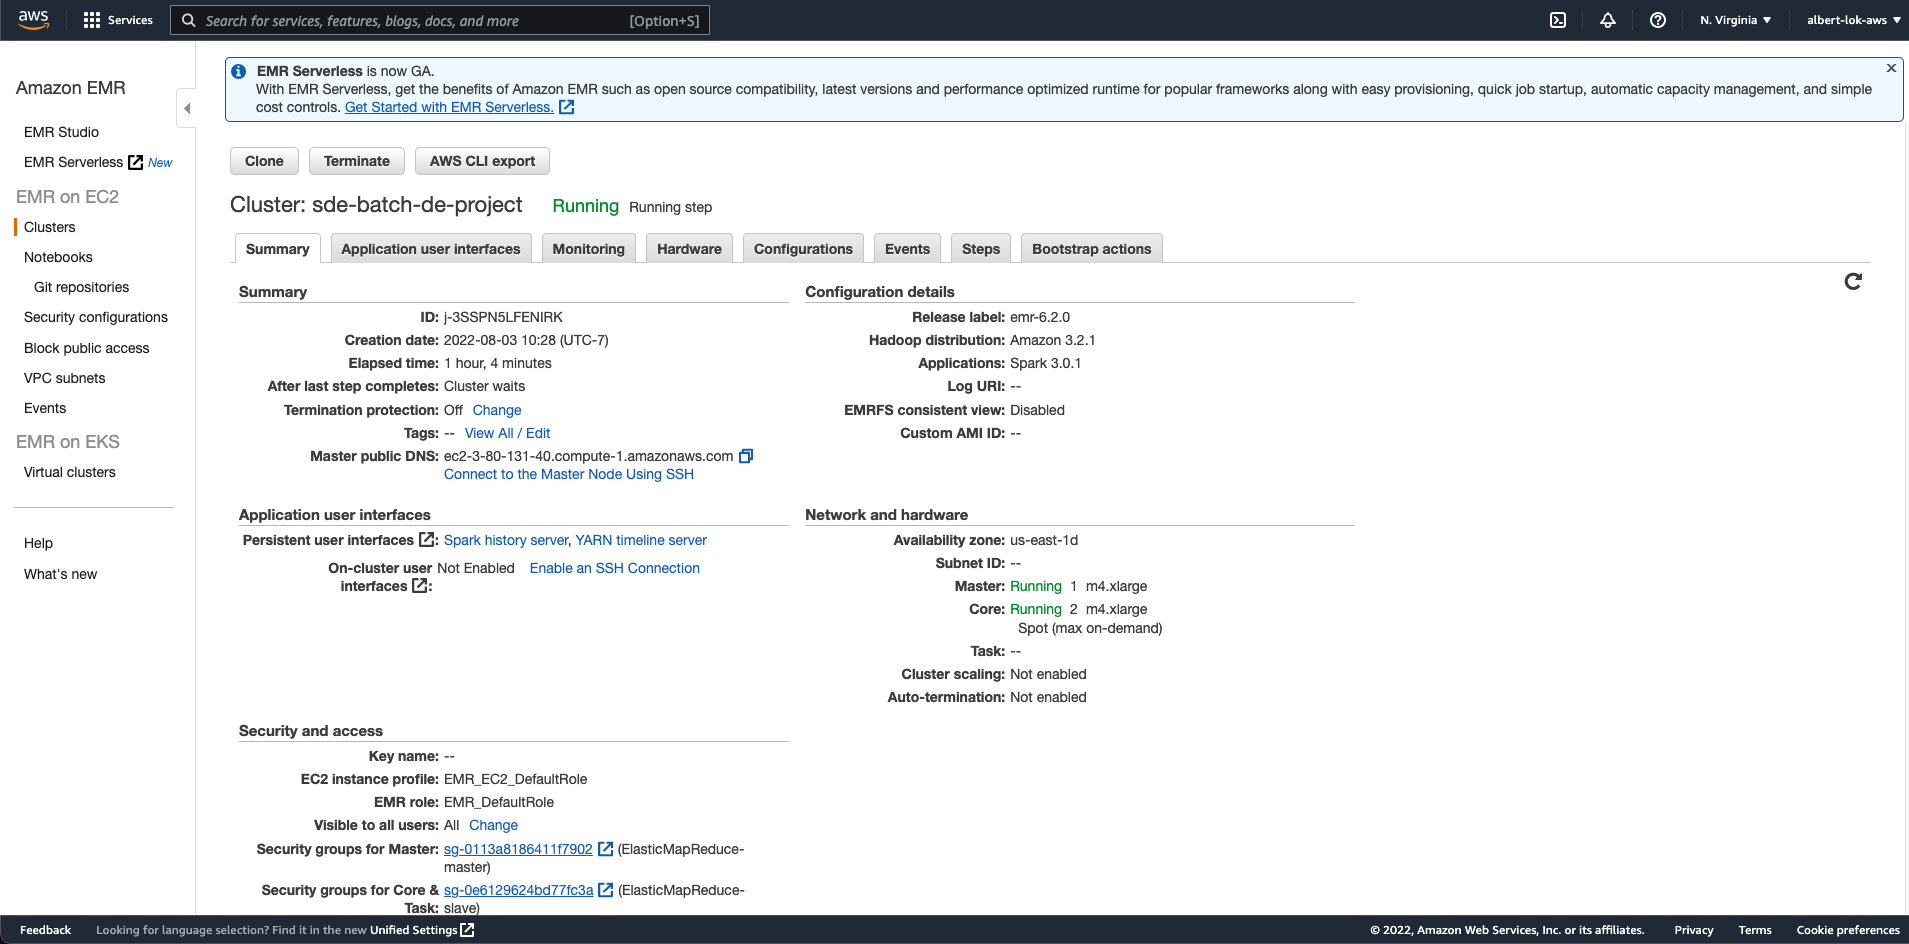

EMR Monitoring:
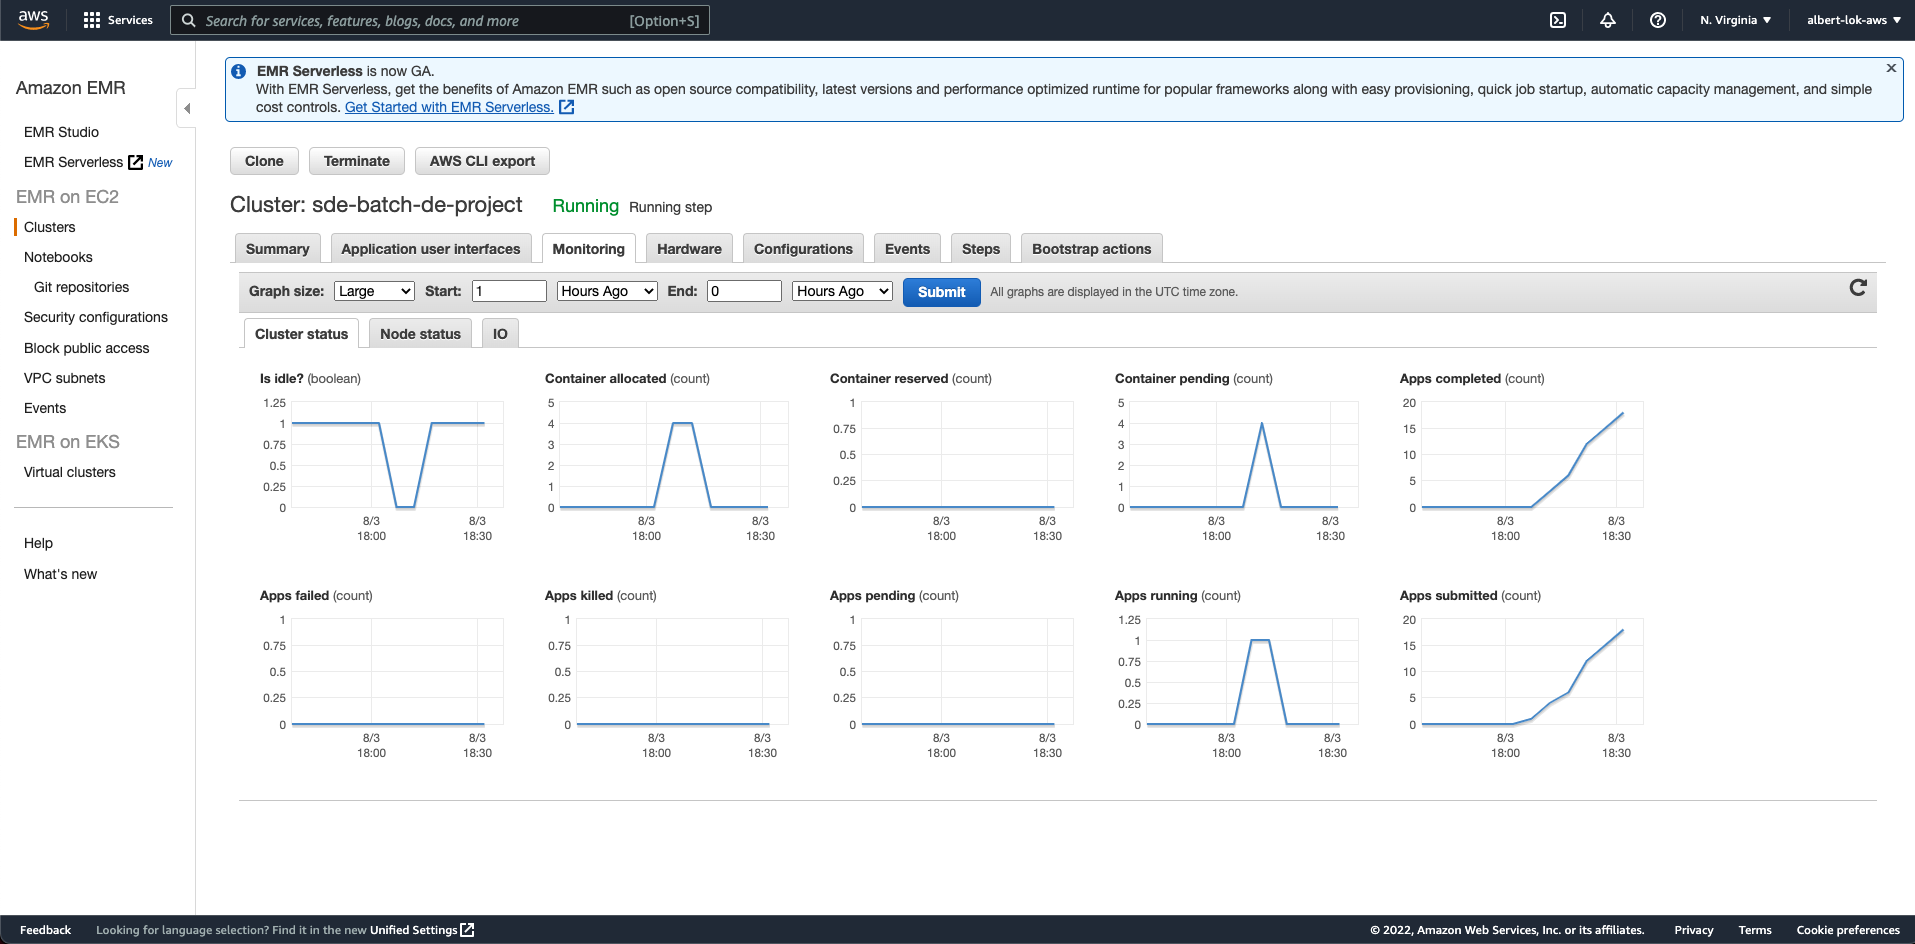

The Redshift Cluster on AWS:
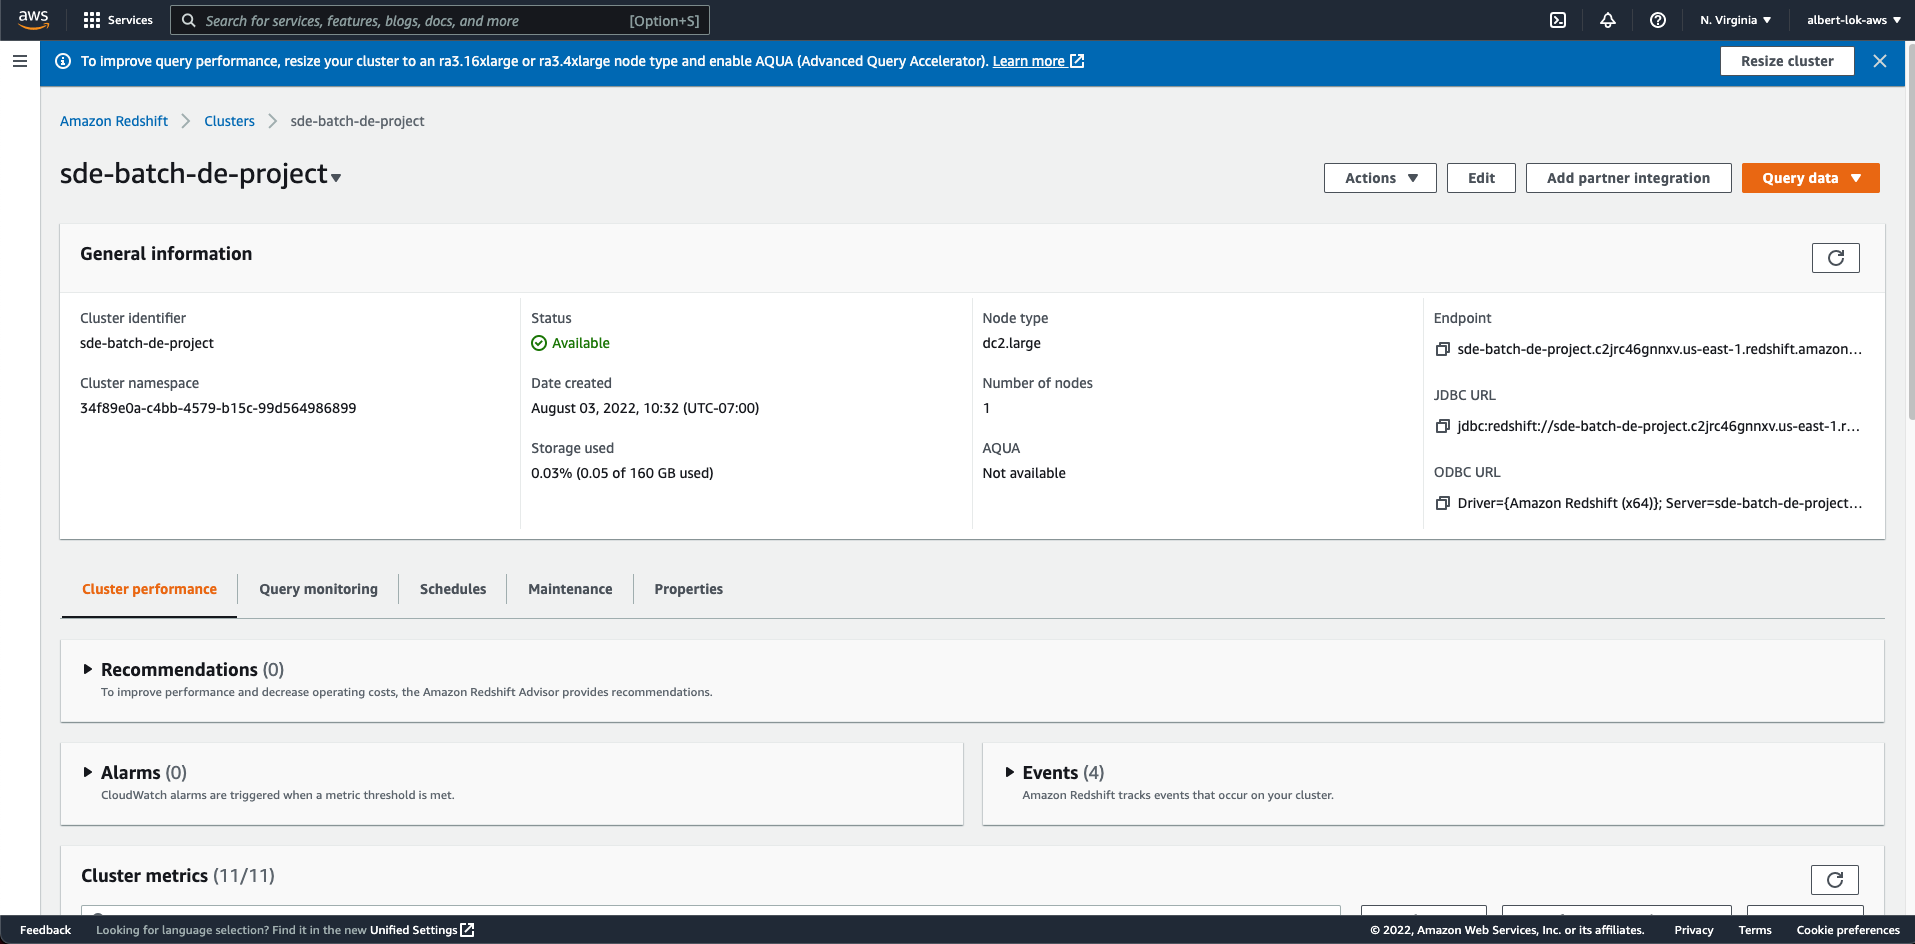

## Checking Results

The `public.user_behavior_metric` Redshift table was checked as shown:
```
export REDSHIFT_HOST=$(aws redshift describe-clusters --cluster-identifier sde-batch-de-project --query 'Clusters[0].Endpoint.Address' --output text)
psql postgres://sde_user:sdeP0ssword0987@$REDSHIFT_HOST:5439/dev
```

Using the SQL prompt, these queries were run to make sure the counts were as expected:
```
SELECT insert_date, count(*) AS cnt
    FROM spectrum.classified_movie_review
    GROUP BY insert_date
    ORDER BY cnt desc; -- 100,000 per day

SELECT insert_date, count(*) AS cnt
    FROM spectrum.user_purchase_staging
    GROUP BY insert_date
    ORDER BY cnt desc; -- 541,908 per day

SELECT insert_date, count(*) AS cnt
    FROM public.user_behavior_metric
    GROUP BY insert_date
    ORDER BY cnt desc; -- 908 per day

\q
```

## Visualizations

Metabase was used to confirm the data by visualization with some aggregations against customerid:

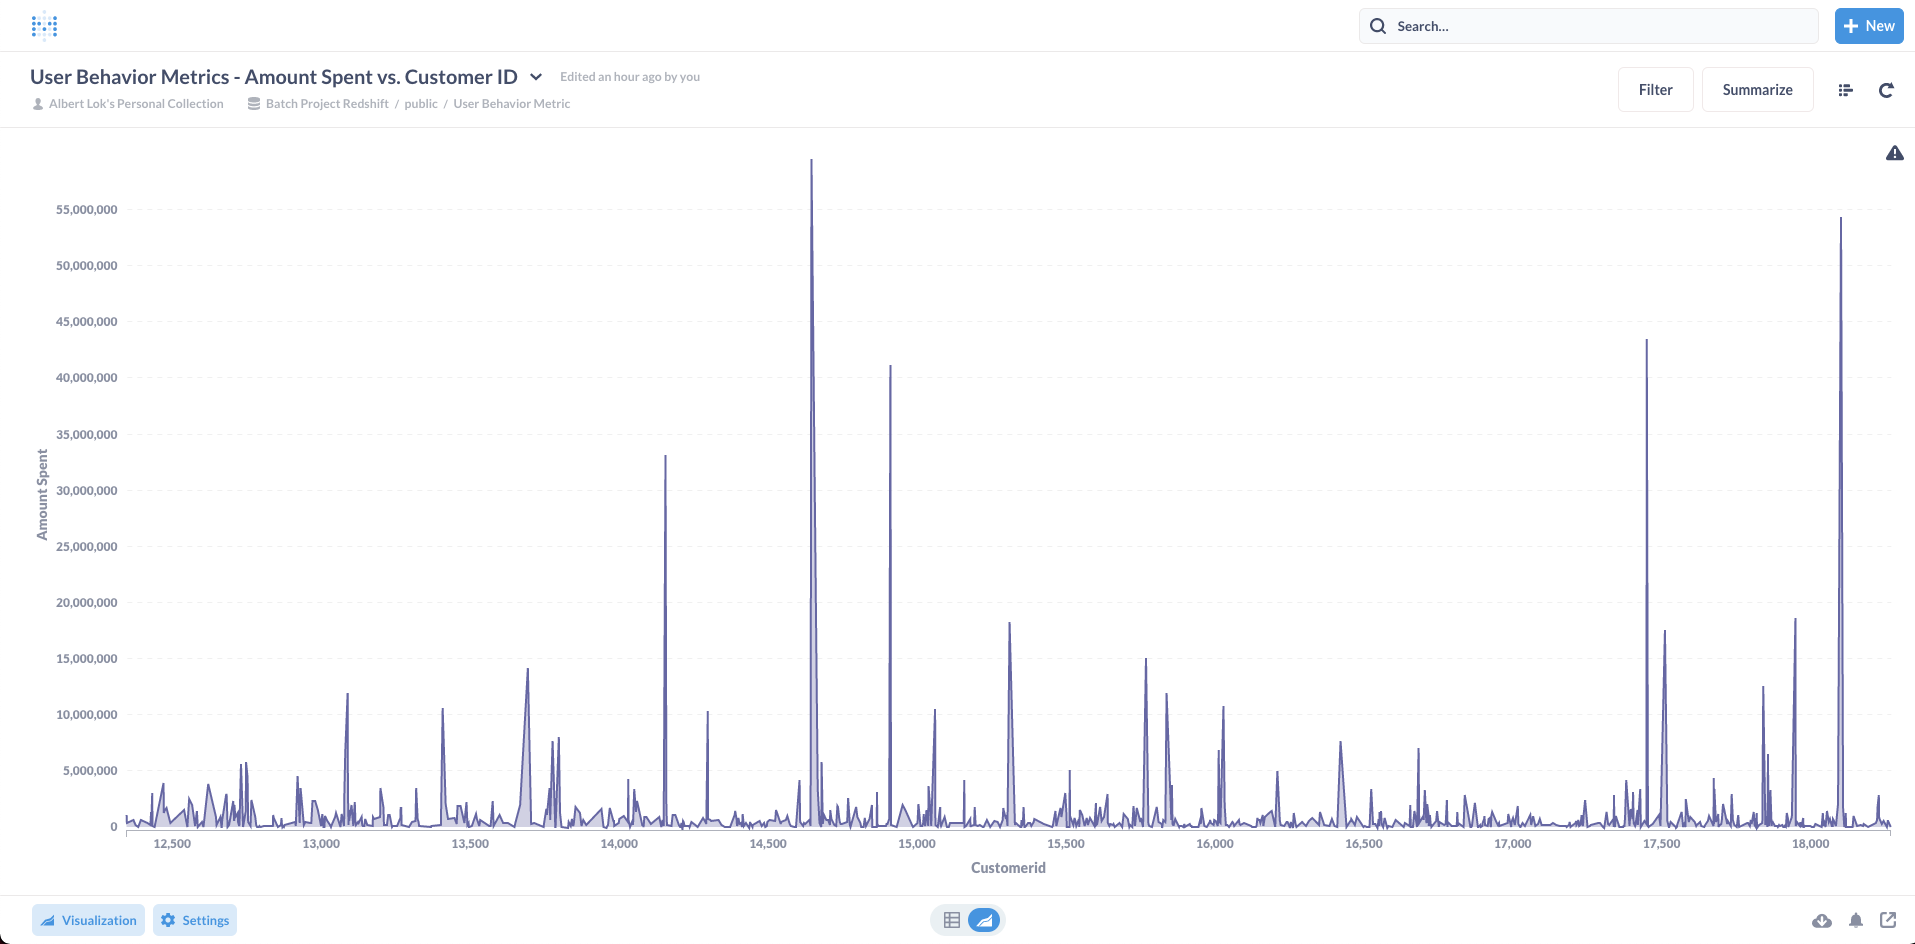

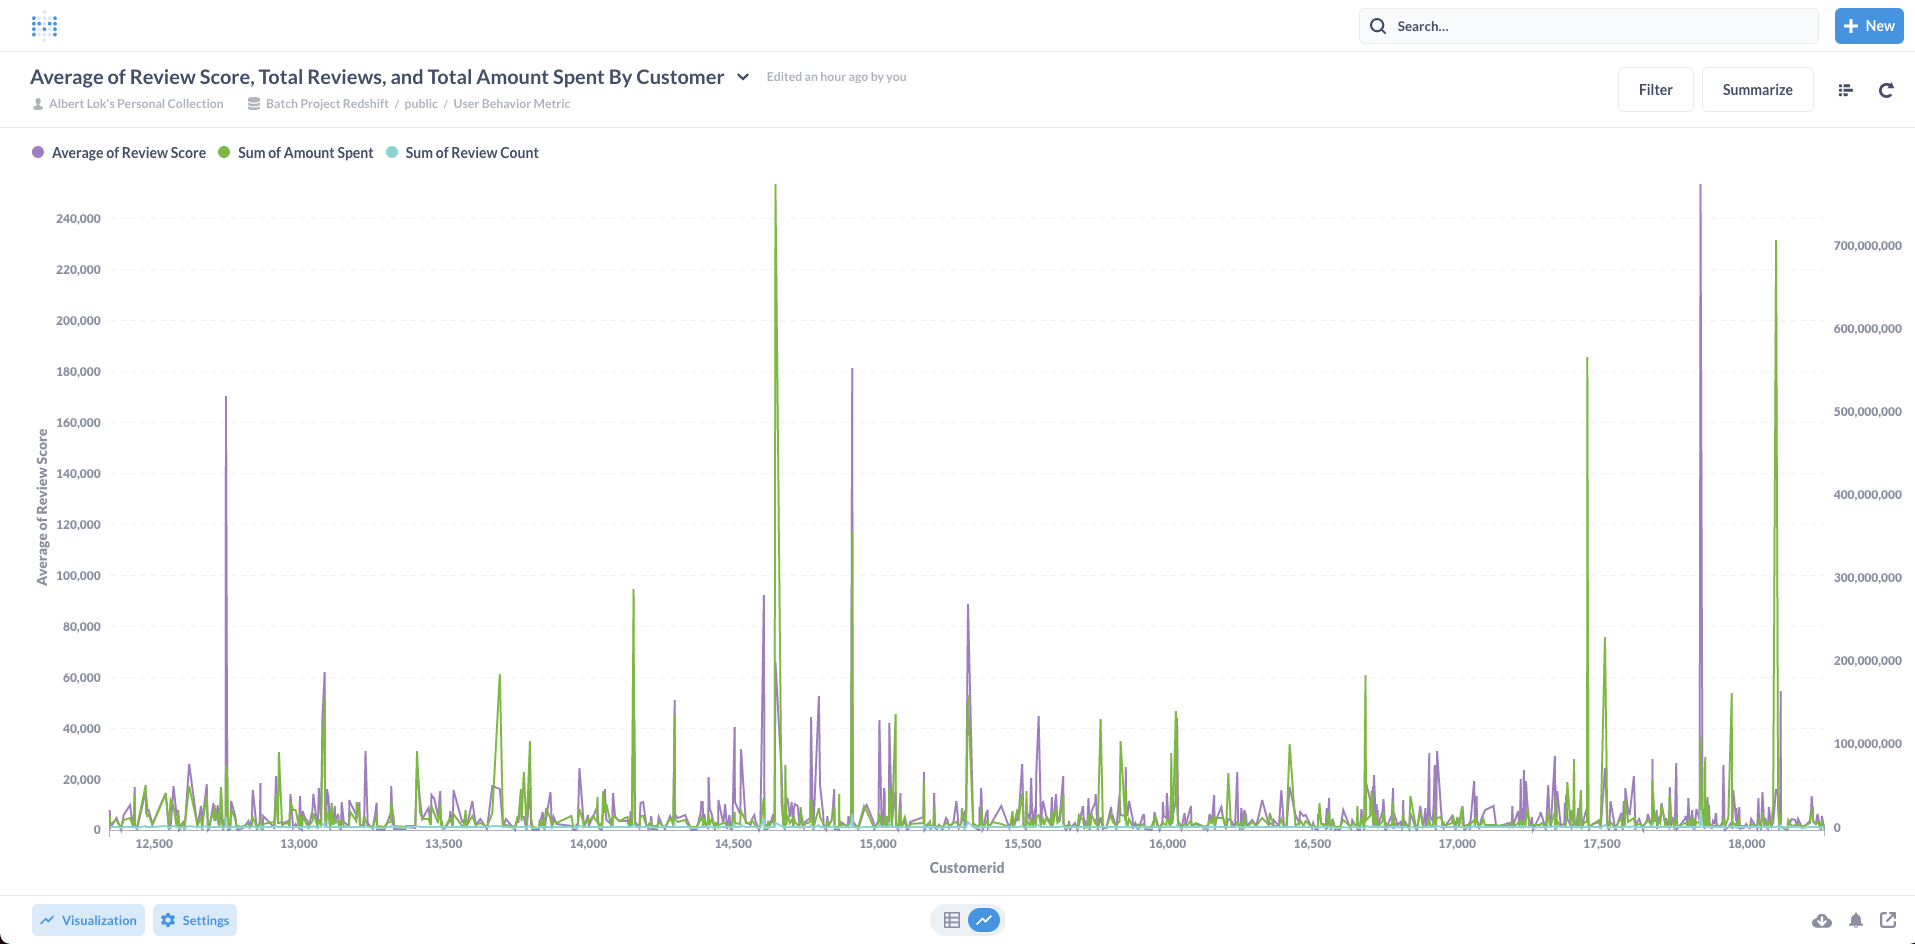

## Costs

This project used:
* 3 m4.xlarge type nodes for our AWS EMR cluster.
* 1 dc2.large for our AWS Redshift cluster.
* 1 iam role to allow Redshift access to S3.
* 1 S3 bucket with about 150MB in size.
* 1 t2.large AWS EC2 instance.

By AWS estimates, the cost would be $313.91 per month, which is approximately 44 cents per hour:
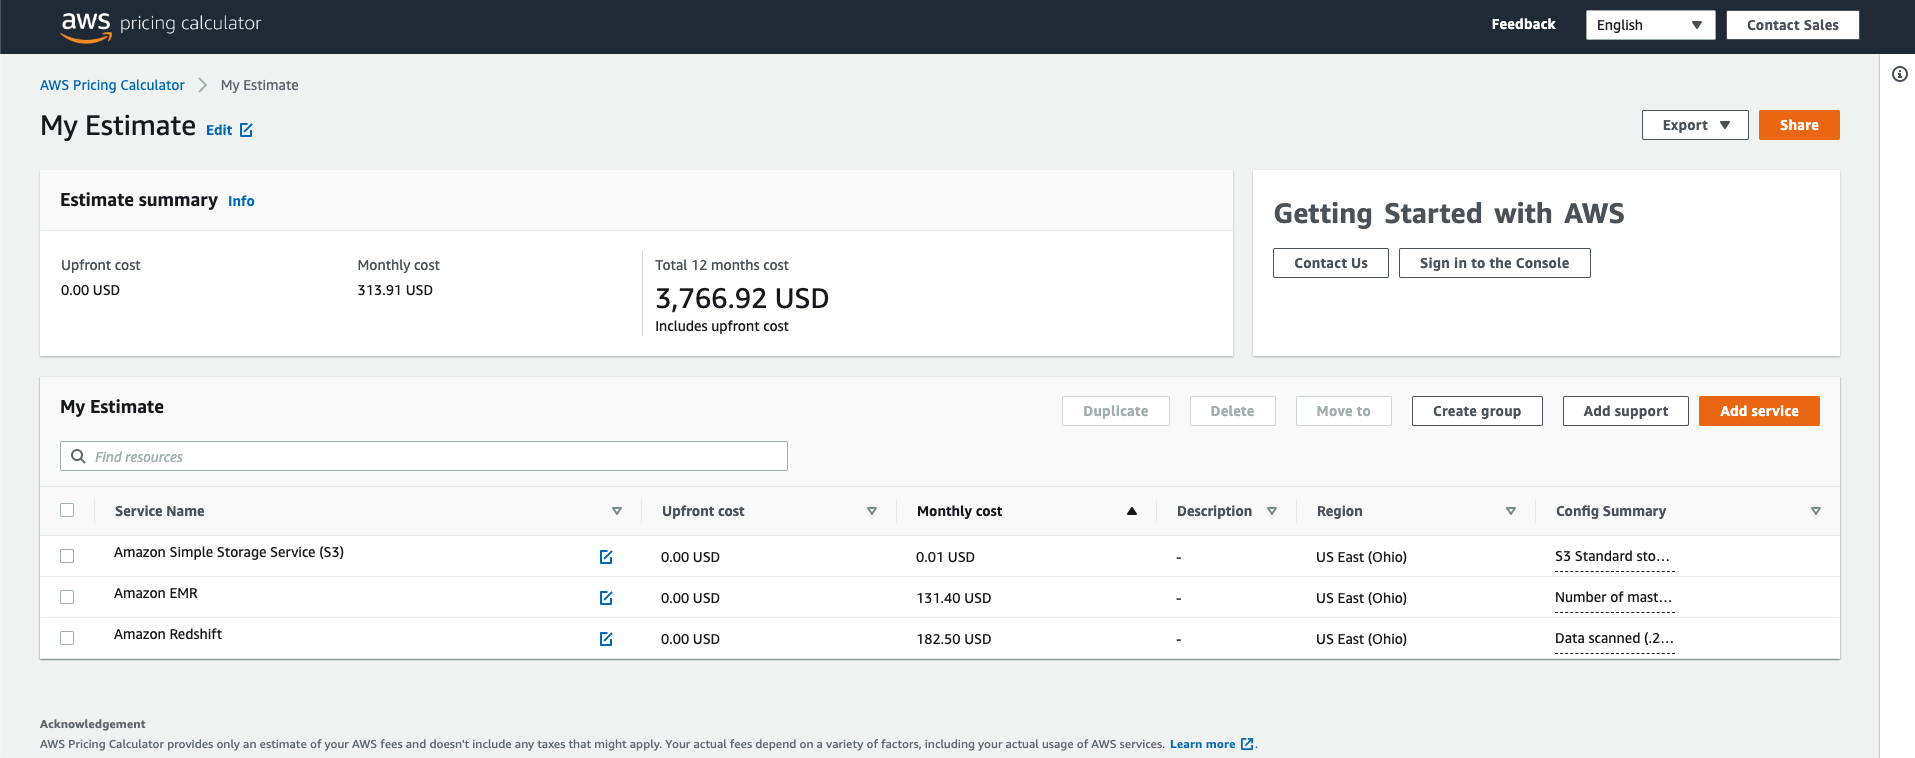

## Conclusions

This project was a good introduction to all the components used in a data pipeline in order to load and aggregate data from different sources into one data warehouse for analysis.  It used a lot of AWS services that are common in data engineering and these tools could become very useful in many applications.

After the project, we ran tear_down_infra.sh to shut down the AWS services and delete IAM users and security groups created specifically for this project.  There was some troubleshooting and debugging required to set everything up and some further exploration was done with monitoring and scheduling tasks on Airflow.

Overall, it was good practice to get a pipeline up and running and see the results.